# Imports

In [ ]:
!pip install pycaret
!pip install scikit-learn==0.23.2
!pip install PyDrive
!pip install googletrans==3.1.0a0
!pip install attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320 kB 5.1 MB/s 
     |████████████████████████████████| 120 kB 33.5 MB/s 
     |████████████████████████████████| 262 kB 30.1 MB/s 
     |████████████████████████████████| 1.3 MB 34.2 MB/s 
     |████████████████████████████████| 17.8 MB 382 kB/s 
     |████████████████████████████████| 1.7 MB 34.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.0 MB 49.1 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 6.8 MB 52.4 MB/s 
     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 167 kB 51.8 MB/s 
     |████████████████████████████████| 1.3 MB 55.5 MB/s 
     |████████████████████████████████| 1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.0 MB/s 
     |████████████████████████████████| 1.3 MB 9.9 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 65 kB 2.9 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=24ce54cda2239e410c28ea08026ca76dece57e7e260604ea01e2366a21f11028
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |█████████████████

In [ ]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from pycaret.classification import *
from nltk.corpus import stopwords, names
import unicodedata
from nltk.stem import PorterStemmer
import re
from collections import Counter
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.model_selection import train_test_split
from tensorflow import keras
from nltk.corpus import wordnet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,MaxPooling1D,Flatten,Layer
from attention import Attention
from tensorflow.keras.layers import LSTM, Embedding,Bidirectional,SpatialDropout1D,InputLayer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers,Model
from tensorflow.keras.layers import Dropout,Input
from tensorflow.keras import callbacks
from nltk.sentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from pycaret.utils import enable_colab
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googletrans import Translator
enable_colab()

nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

Colab mode enabled.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

 # Functions

In [ ]:
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')


def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict

def computeIDF(documents):
    import math
    N = len(documents)

    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
        return idfDict

def computeTFIDF(tfBagOfWords, idfs):
    tfidf = {}
    for word, val in tfBagOfWords.items():
        tfidf[word] = val * idfs[word]
    return tfidf

#Replacing wrongly translated product names
def filter(all_filtered,category,descriptions,removable):
  for index,sentence in enumerate(all_filtered):
        all_filtered[index] = [e for e in all_filtered[index] if e not in removable]
        if not all_filtered[index]:
          # print('category :' ,category[index+1])
          # print('all filtered :' ,all_filtered[index+1])
          # print('descriptions:' ,descriptions[index+1])
          category.pop(index)
          all_filtered.pop(index)
          descriptions.pop(index)
          # print('new category :' ,category[index ])
          # print('new all filtered :' ,all_filtered[index ])
          # print(' new descriptions:' ,descriptions[index])


  # all_filtered = [e for e in all_filtered if e]
  return all_filtered,category,descriptions

# Preprocessing

In [ ]:
# pd.options.display.max_colwidth = 200
# df[df['eng_comment']== 'cussio ice cream products']['comment']

In [ ]:
df = pd.read_csv('/content/sefco_eng_comments.csv')
del df['Unnamed: 0']

In [ ]:
df[df.duplicated(subset='comment')].sort_values(by=['comment'])[['Customer','category','comment']]

In [ ]:
df[df['comment']=='κλασικός ξυλόφουρνος']

Customer                 Date  category               comment        eng_comment
312  C.02179  2021-09-28 11:54:16        -1  κλασικός ξυλόφουρνος  classic wood oven

In [ ]:
# A.00855	2021-12-09 11:53:44	0	έγινε είσπραξη ο πελάτης δεν χρειαζόταν κάτι	was collected the customer did not need anything
# 1194	A.00891	2021-12-09 13:39:48	0	έγινε είσπραξη ο πελάτης δεν χρειαζόταν κάτι	was collected the customer did not need anything
# 1488	A.06900	2022-01-04 09:31:08	0	έγινε είσπραξη από τον πελάτη δεν χρειαζόταν κάτι	was collected by the customer did not need anything
# 1571	A.00934	2022-01-10 11:09:48	-1	έγινε είσπραξη ο πελάτης δεν χρειαζόταν κάτι	was collected the customer did not need anything
# 1591	A.06900	2022-01-11

pd.options.display.max_colwidth = 500
df[df['Customer']=='A.00934'].sort_values(by='Date')[['Date','Customer','category','comment']]

In [ ]:
df = df.drop_duplicates(subset='eng_comment', keep="last")
df = df.reset_index()
del df['index']

In [ ]:
# removing english unimportant words

non_removable = set(["event","good","stock","start","stand","ok","messenge","direct","okay"
    ,"brands","control","credit",'no',"comment","bakery","stolen"
    ,"pretty","full","fresh","ever", "easy","cost","open","days"
    ,"bakery", 'general', 'direct', 'easy', 'top',
    'rich', 'free', 'in', 'best', 'game', 'dream','feedback','fit','stop'])


english_in_greek = set()
for i in df['comment']:
  for j in nltk.word_tokenize(i):
    if j.encode().isalpha():
         english_in_greek.add(j.lower())

english_in_greek = english_in_greek-non_removable      #cussio

days = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday','cussio']

top30_removal = ['customer','dachshund','product','price','christos','place','royal','pie','make','bag','palette','order']

top30_v2_removal = [ 'work','strawberry','place','western','factory','new','chestnut',
                     'update','price','excpect','stop','anything','place','product','buy','total','winter','bag','nut','idea','question',
                     'excpect','considers','made','making','work','saki','chorus','menu','desda','estate','parmaxizoglou',
                     'third','reception','quartet','whole','take','towards','bueno',
                     'raw','offer','get','melomakarono','whether','dessert','two','product','work','modern','place','expect','christos']

In [ ]:
stop_words = stopwords.words("english")
for i in range(len(stop_words)):
  stop_words[i] = strip_accents(stop_words[i])

stop_words.remove("not")
stop_words.remove("no")

In [ ]:
comment = df['eng_comment'].to_list()
category = df['category'].to_list()

In [ ]:
descriptions = []  # store comment descriptions
for i in range(df.shape[0]):
  if (isinstance(comment[i],float)):
    l = ''
  else:
    l = comment[i]

  descriptions.append(l)

In [ ]:
all_tokenized = [] # Tokenization ,stop word removal

for i in comment:

    string = i.lower()
    string = re.sub(r'[^\w\s]','',string)
    string = ''.join(j for j in string if not j.isdigit())
    all_tokenized.append(nltk.word_tokenize(string))


all_filtered = [] # filter stopwords
for i in all_tokenized:
    current_filtered = []
    for w in i:
        if w not in stop_words:
            current_filtered.append(w)

    all_filtered.append(current_filtered)

#all_filtered

In [ ]:
# Stemming
ps = PorterStemmer()
all_stemmed = []

for i in all_filtered:
    current_stemmed=[]
    for x in i:
        current_stemmed.append(ps.stem(x))
    all_stemmed.append(current_stemmed)

In [ ]:
# lemmatization

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


# tagging
all_tagged = []
for i in all_filtered:
 all_tagged.append(nltk.pos_tag(i))


lemmatizer = WordNetLemmatizer()
all_lemmatized = []

for sentence in all_tagged:
  current_lemmatized = []
  for word,tag in sentence:
    tag = get_wordnet_pos(tag)
    if tag is None:
        current_lemmatized.append(word)
    else:
        current_lemmatized.append(lemmatizer.lemmatize(word,tag))
  all_lemmatized.append(current_lemmatized)


In [ ]:
# Removing sequential duplicate words

for index,i in enumerate(all_lemmatized):
  prev=''
  for j in i:
    current = j
    if current == prev:
      all_lemmatized[index]= list(set(all_lemmatized[index]))
    prev = j

In [ ]:
# filtering specific unimportant words

all_lemmatized,category,descriptions = filter(all_lemmatized,category,descriptions,english_in_greek)
all_lemmatized,category,descriptions = filter(all_lemmatized,category,descriptions,days)
all_lemmatized,category,descriptions = filter(all_lemmatized,category,descriptions,top30_removal)
all_lemmatized,category,descriptions = filter(all_lemmatized,category,descriptions,top30_v2_removal)

In [ ]:
print("Original ||" , all_filtered[629]) # test results
print("Original Greek || ", df.iloc[629]['comment'])
print("Lemma ||" , all_lemmatized[629])
print("Stem ||" , all_stemmed[629]) # prepei na fygei to no - stop words? // ola ta arnitika se no ?


Original || ['offer', 'mom', 'collected', 'waiting', 'order']
Original Greek ||  έγινε είσπραξη ενημέρωση της προσφοράς για το μαμάς και Αναμένουμε παραγγελία
Lemma || ['recently', 'coronavirus', 'store', 'closure', 'not', 'yet', 'return', 'trust', 'mom', 'company']
Stem || ['offer', 'mom', 'collect', 'wait', 'order']


In [ ]:
# Bigrams Trigrams

bigram = gensim.models.Phrases(all_filtered, min_count=3, threshold=1) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[all_filtered], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


all_filtered = make_bigrams(all_lemmatized)

# Text to sequences

In [ ]:
max_len = 0
for i in all_lemmatized:
  if len(i)>max_len:
    max_len = len(i)
print(max_len)

uniqueWords = set()
for i in all_lemmatized :
    uniqueWords = uniqueWords.union(set(i))

max_words = len(uniqueWords)
tok = Tokenizer()
tok.fit_on_texts(np.asarray(all_lemmatized))
sequences = tok.texts_to_sequences(np.asarray(all_lemmatized))
X = sequence.pad_sequences(sequences,maxlen=max_len)
X = X.astype(float)

27


# GloVe

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"18Z7DdSSkb2safrg_mP0DVfl1RCAU7gI6"})
downloaded.GetContentFile('glove.txt')

In [ ]:
f = open('/content/glove.6B.100d.txt') #import file

In [ ]:
f = open('glove.txt') # google drive mount

In [ ]:
embeddings_index = dict()
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(uniqueWords)+1, 100))
for word, i in tok.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1499, 100)

In [ ]:

for i,sent in enumerate(sequences):
  for i2,word in enumerate(sent):
    sequences[i][i2] = embedding_matrix[word]
X = sequence.pad_sequences(sequences,maxlen=max_len, dtype='float32')

# Change Representation based on frequency


In [ ]:
#adding tf idf to vectorized representation

uniqueWords = set()
for i in sequences :
    uniqueWords = uniqueWords.union(set(i))

my_dict = dict.fromkeys(uniqueWords, 0) #poses fores exe ifanei h lexh auth synolika
my_dict_2= dict.fromkeys(uniqueWords, 0) # se poses protaseis yparxei h lexh auth

c =0
for i in sequences:
  seen=[]
  for j in i:

    if j not in seen:
      my_dict_2[j]=my_dict_2[j]+1
    seen.append(j)
    my_dict[j]=my_dict[j]+1
# length = len(uniqueWords)
# for value in my_dict.keys():
#   my_dict[value] = my_dict[value]/length

# tf_dict = my_dict

In [ ]:
doc_len = X.shape[0]
for i in range(1,len(my_dict)):
  my_dict[i]= np.log(i* doc_len/my_dict[i]) #* np.log(doc_len/my_dict_2[i])


In [ ]:
for (index,sentence) in enumerate(X):
  for (index_2,word) in enumerate(sentence):
    if word>0:
      X[index][index_2]=my_dict[word]

# BoW

In [ ]:
# Convert to Vectors (1,#words) bag of words - > dokimi word embeddings

uniqueWords = set()
for i in all_filtered :
    uniqueWords = uniqueWords.union(set(i))


word_list = []
for i in uniqueWords:
  word_list.append(i)

all_dictionaries=[]
for i in all_filtered :

      my_dict= dict.fromkeys(uniqueWords, 0)
      for word in i:
         my_dict[word] += 1
      all_dictionaries.append(my_dict)


In [ ]:
# tf - idf

idf_list=[]
idf_list = computeIDF(all_dictionaries)

tf_idf_list = []
for i in range(len(all_filtered )):

    tf_list = computeTF(all_dictionaries[i],all_filtered [i])
    tf_idf_list.append(computeTFIDF(tf_list,idf_list))

In [ ]:
final_array = []
for d in tf_idf_list:
    temp=[]
    temp=list(d.values())
    final_array.append(temp) ##input for neural net


X = np.asarray(final_array)


In [ ]:
# BoW Embedding
embedding_matrix = np.zeros((len(uniqueWords)+1, 100))
for word, i in enumerate(word_list):
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

# Simple

In [ ]:
# under = NearMiss(version=1, n_neighbors=3)
# X_under, y_under = under.fit_resample(X, y)
# counter = Counter(y_under)
# print(counter)

# X_under = pd.DataFrame(X_under)
# X_under.insert(X_under.values.shape[1], 'labels', y_under)

# exp_mclf101 = setup(data = X_under, target = 'labels', session_id=123)

# best = compare_models()

# type(predict_model(best))

Counter({0: 142, 1: 142, 2: 142})


In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

clf = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
kfold = KFold(10, True, 1)


acc_list = []
importance_accu = np.zeros(X.shape[1])
for train_index, test_index in kfold.split(X):

  strategy = {1: Counter(y[train_index])[1], 0:Counter(y[train_index])[0], 2:Counter(y[train_index])[0]}
  over = SMOTE(sampling_strategy=strategy)
  X_over, y_over = over.fit_resample(X[train_index], y[train_index])
  under = NearMiss(version=1, n_neighbors=3)
  X_under, y_under = under.fit_resample(X_over, y_over)
  clf.fit(X_over, y_over)
  importance_accu = importance_accu + clf.feature_importances_
  pred = clf.predict(X[test_index])
  acc_list.append(accuracy_score(y[test_index],pred ))

print('accuracy : ', sum(acc_list)/len(acc_list))
print('std : ', np.std(acc_list))

accuracy :  0.6961483870967741
std :  0.05724888104455213


In [ ]:
# all dataset over \\\\ accuracy :  0.7646666666666667 std :  0.0350044754184563
# all dataset nearmiss \\\\ accuracy :  accuracy :  0.7392035794183445 std :  0.04623623155706692


# reduced dataset over \\\\ accuracy :   0.7646666666666666 std :  0.02813459712801226
# reduced dataset nearmiss \\\\ accuracy :  accuracy :  0.7539999999999999 std :  0.030177254127350082

# ///////////////////////

# reduced_τοπ30 dataset over \\\\ accuracy :   0.76210240853098 std :  0.04601641216602427
# reduced_τοπ30  dataset nearmiss \\\\ accuracy :  accuracy :  0.7627826806398235 std :  0.03720671375229303

# ///////////////////////

# reduced_τοπ30_v2 dataset over \\\\ accuracy :   0.7537093215664644 std :  0.03244879365309446
# reduced_τοπ30_v2  dataset nearmiss \\\\ accuracy :  accuracy :  0.75438499724214 std :  0.024306273067535553

In [ ]:
forest_importances=pd.Series(importance_accu)
for i in forest_importances.sort_values(axis=0, ascending=False).head(30).index:
  print(word_list[i])

collection
no_comment
not
excite
cooperation
pleased
exclusively
happy
quality
not_need
balance
absolutely_happy
collect
problem
complain
already
exist
reopen
happy_cooperation
close
shortage
not_want
partner
dissatisfaction
watch
demonstration
wider
hike
ask
completely


# LSTM

In [ ]:
y = pd.Series(category)
y = y+1

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15, random_state=4 )

In [ ]:
# Class balancing
c = Counter(y_train)
print(c)
strategy = {1: c[1], 0: c[0], 2: 400}
over = SMOTE(sampling_strategy=strategy)

X_over, y_over = over.fit_resample(X_train, y_train)
counter = Counter(y_over)
print(counter)

under = NearMiss(version=1, n_neighbors=3)
X_under, y_under = under.fit_resample(X_over, y_over)
counter = Counter(y_under)
print(counter)

Counter({0: 549, 1: 521, 2: 141})
Counter({0: 549, 1: 521, 2: 400})
Counter({0: 400, 1: 400, 2: 400})


In [ ]:
# stin periptosi tou BOW
X_over = X_over.reshape(X_over.shape[0],1,X_over.shape[1])
X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [ ]:
import keras.backend as K
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [ ]:
input_dim = X.shape[1]
output_dim = y.shape[0]

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    min_delta=0.1,
    restore_best_weights=True,
)
# voc_2 = int(my_dict[len(my_dict)-1])+1
voc = len(uniqueWords)+1

input_tensor = Input(shape=(27,))
input_shape = Embedding(voc, 100,weights=[embedding_matrix], input_length=X.shape[1])(input_tensor)


parallel_conv_1 = Conv1D(filters=50, kernel_size=1, activation='relu')(input_shape)
parallel_conv_1 = MaxPooling1D(pool_size=4)(parallel_conv_1)

parallel_conv_2 =  Conv1D(filters=50, kernel_size=2, activation='relu')(input_shape)
parallel_conv_2 = MaxPooling1D(pool_size=3)(parallel_conv_2)

parallel_conv_3 =  Conv1D(filters=50, kernel_size=3, activation='relu')(input_shape)
parallel_conv_3 = MaxPooling1D(pool_size=2)(parallel_conv_3)

merged = keras.layers.concatenate([parallel_conv_1, parallel_conv_2, parallel_conv_3], axis=1)


lstm = Bidirectional(LSTM(50, return_sequences = True))(merged)
attention_layer = Attention(units=32)(lstm)

out = Dense(3, activation='softmax')(attention_layer)
model = Model(input_tensor, out)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_under, y_under, epochs=100,validation_data=(X_test, y_test),callbacks=[early_stopping])

### evaluate the model
loss,accuracy = model.evaluate(X_test, y_test, verbose=0)

print('test set accuracy ' , accuracy)
print()
model.summary()

Epoch 1/100
38/38 [==============================] - 12s 113ms/step - loss: 1.0160 - accuracy: 0.4858 - val_loss: 1.1006 - val_accuracy: 0.4019
Epoch 2/100
38/38 [==============================] - 3s 67ms/step - loss: 0.8789 - accuracy: 0.6067 - val_loss: 1.0807 - val_accuracy: 0.5140
Epoch 3/100
38/38 [==============================] - 3s 67ms/step - loss: 0.7258 - accuracy: 0.7117 - val_loss: 1.0730 - val_accuracy: 0.5561
Epoch 4/100
38/38 [==============================] - 3s 68ms/step - loss: 0.5759 - accuracy: 0.7867 - val_loss: 0.9971 - val_accuracy: 0.6121
Epoch 5/100
38/38 [==============================] - 1s 34ms/step - loss: 0.4472 - accuracy: 0.8275 - val_loss: 1.1773 - val_accuracy: 0.5888
Epoch 6/100
38/38 [==============================] - 2s 55ms/step - loss: 0.3323 - accuracy: 0.8800 - val_loss: 1.2704 - val_accuracy: 0.5888
Epoch 7/100
38/38 [==============================] - 2s 64ms/step - loss: 0.2674 - accuracy: 0.9117 - val_loss: 1.3715 - val_accuracy: 0.5935
Epoc

                                 Plot



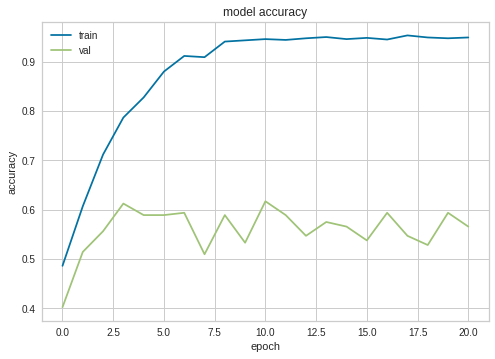



                      Classification report

              precision    recall  f1-score   support

           0       0.77      0.64      0.70        98
           1       0.67      0.64      0.65        91
           2       0.24      0.44      0.31        25

    accuracy                           0.62       214
   macro avg       0.56      0.57      0.56       214
weighted avg       0.66      0.62      0.63       214






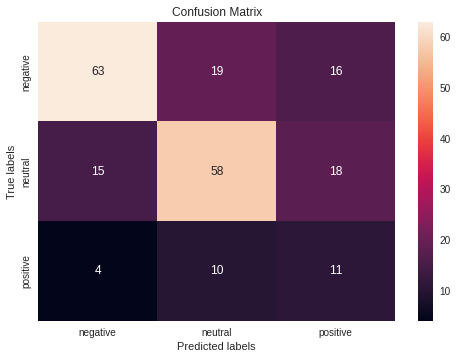

In [ ]:
print("                                 Plot")
print()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

print()
print()
print("                      Classification report")
print()
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))
print()
print()

print()
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test, y_pred_bool), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative','neutral', 'positive']); ax.yaxis.set_ticklabels(['negative','neutral', 'positive']);

In [ ]:
verdict = []
for t in model.predict(X):
  M = max(t)
  V = t.tolist().index(M)
  verdict.append(V-1)


answers = pd.DataFrame({'Comments': descriptions[:X.shape[0]], "Prediction": verdict, "Real": y-1})
print(answers)

                                               Comments  Prediction  Real
0     the customer closes today and opens at the end...           0     0
1     I see that there was a change in the way of co...           0     0
2     Katerina I see that at the top right of the sc...          -1     0
3     We talked about closing the company and I expe...           0     0
4     now one of our best customers has shops in Arg...           1     1
...                                                 ...         ...   ...
1239                                     order delivery           0     0
1240  we changed again and got the cake from laoudi ...           0     0
1241            Homemade cake from laoudi 2.70 per unit           0     0
1242  nucrema praline from a frumel dealer 2 euros a...           1    -1
1243                               collection and order           0     0

[1244 rows x 3 columns]


In [ ]:
answers[answers['Prediction'] != answers['Real']].to_csv('predictions.csv')

In [ ]:
answers[answers['Prediction'] != answers['Real']].tail(20)

In [ ]:
accuracy_score(answers['Prediction'].to_list(), answers['Real'].to_list())

In [ ]:
answers[answers['Prediction'] != answers['Real']]

Comments  Prediction  Real
2     Katerina I see that at the top right of the sc...          -1     0
22    happy with our cooperation considers the price...           1    -1
32    seasonal customer in Halkidiki happy with the ...           1     0
33    horeca dealer in the first leg strong we are t...           1     0
35    collection and closing season for the specific...           1     0
45    franchise member is happy with our products th...           0     1
55    the customer complained about product shortage...          -1     0
61    I have a serious problem with this customer du...           1    -1
63    moderate oven relatively good range of snacks ...          -1     0
64    the client started a collaboration and with my...           1    -1
72    The yeasts were presented but the customer was...           0    -1
77    work four people family business 18 flavors of...          -1     1
84    is famous for its tulips and syrups it makes 1...           1     0
86    happy with our cooperation they work on a prod...           1     0
89    the customer was absent I learned that his bro...           1     0
99    the only confectionery in the area of Argos Or...           1     0
101   I stopped making cakes and Marfin only ice cre...           0    -1
103   coffee bar making pancakes and waffles moderat...          -1     0
122   happy with our cooperation complaint about the...           1    -1
126   discussion on whether and to what extent it is...           1     0
131   bakery with two stores ends wholesale in the v...           1    -1
133      his shop has been destroyed by the August fire           0    -1
134   stopped working because he waited 20 days for ...           0    -1
136            brings products and mixtures from abroad           0    -1
139   Receipts were made to the customer Also placin...           1    -1
144                                 permanently missing           0    -1
146   considers the syrups closest the bueno is quit...           1    -1
147                           cussio ice cream products           0    -1
148                        pernicoti ice cream products           0    -1
150   the customer makes wholesale in the area On th...          -1     0
156   bad payer has many openings in the market has ...           1    -1
159   connoisseur of bakery vikato yeasts special br...           1    -1
172   opens a new shop very large one square next to...           1     0
173   interest in red forest if pancake can be made ...           0     1
176                    He wants attention with the rest           0    -1
180   they asked if we would make bids to offset the...           1    -1
181   classic bakery makes wholesale in the surround...           1     0
183       question about whether to reopen horeca offer           0     1
198   makes wholesale in tarts the Red forest will t...          -1     0
199   has a technical problem with the doll I will c...           0    -1
205   the customer complained to you about the packa...           1    -1
209   all the samples we have sent to the customer d...           1    -1
210   the customer opens a new store and was interes...           1     0
213   The dates for the upcoming bakery days were co...           1     0
217   the customer Tomorrow will go to Athens to att...           0    -1
228   I contacted the dates for the bakery days and ...           1    -1
236   the customer complained that lately Mamas cake...           1    -1
241   interest in whether the horeca offer will reop...           0     1
244   the customer requested a two-day technical dem...           1     0
246   update on upcoming price hike interest on whet...           0     1
255   recipes for the Red Forest Fruit cake received...           1     0
266                 family pastry shop make a few codes           0    -1
267                      they went to a show by Laoudis           0    -1
269   There was communication and promotion with a 